In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
#import os
#os.environ['CUDA_VISIBLE_DEVICES'] = '7'

In [3]:
import sys
LOCAL_FAST_AI = '/Users/krishnakalyan3/Educational/FastAI/fastai/'
AWS_FAST_AI = '/home/ubuntu/fastai'
sys.path.append(AWS_FAST_AI)

In [4]:
from fastai.transforms import * 
from fastai.conv_learner import * 
from fastai.model import *
from fastai.dataset import * 
from fastai.sgdr import *
from fastai.plots import *

In [5]:
PATH = '/home/ubuntu/Plant/data_all/'

In [6]:
label_csv = f'{PATH}all.csv'
n = len(list(open(label_csv)))-1
val_idxs = get_cv_idxs(n, val_pct=.0004)
n, len(val_idxs)

(5544, 2)

In [7]:
torch.cuda.device_count()
#torch.cuda.set_device(7)
#torch.cuda.current_device()

8

In [8]:
f_model = resnet152
sz=250
tfms = tfms_from_model(f_model, sz, aug_tfms=transforms_top_down, max_zoom=1.05)

In [9]:
data = ImageClassifierData.from_csv(PATH, folder='all_train', csv_fname=f'{PATH}all.csv',
                                    tfms=tfms, val_idxs=val_idxs,  bs=64)

In [10]:
learn = ConvLearner.pretrained(f_model, data, precompute=True)
learn.models.model = torch.nn.DataParallel(learn.models.model,device_ids=list(range(0,8)))

A Jupyter Widget

epoch      trn_loss   val_loss   <lambda>                  
    0      0.511933   0.156549   0.925926  



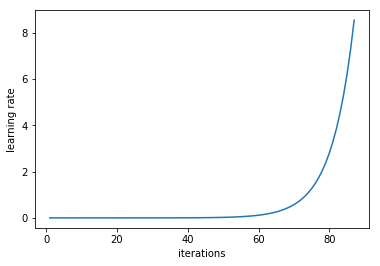

In [11]:
lrf=learn.lr_find()
learn.sched.plot_lr()

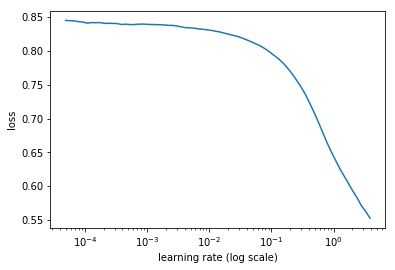

In [12]:
learn.sched.plot()

In [ ]:
learn.precompute=False
lr = 1e-1
learn.fit(lr, 3, cycle_len=1)

A Jupyter Widget

epoch      trn_loss   val_loss   <lambda>                  
    0      0.265503   0.09238    0.981481  
    1      0.127861   0.046925   0.962963                  
    2      0.096995   0.04168    0.981481                   



[0.041679554, 0.98148149251937866]

In [ ]:
learn.unfreeze()
lr=np.array([lr/18,lr/6,lr/2])
learn.fit(lr, 3, cycle_len=2, cycle_mult=4)

A Jupyter Widget

epoch      trn_loss   val_loss   <lambda>                   
    0      0.088864   0.039421   1.0       
    1      0.078066   0.043884   0.981481                   
    2      0.071316   0.043689   0.981481                   
    3      0.06328    0.019224   1.0                        
    4      0.058347   0.016216   1.0                        
    5      0.05324    0.015211   1.0                        
    6      0.051373   0.013949   1.0                        
    7      0.049787   0.011765   1.0                        
    8      0.047823   0.013552   1.0                        
    9      0.046969   0.015564   1.0                        
    10     0.048429   0.015997   1.0                        
    11     0.046835   0.016842   1.0                        
    12     0.045182   0.012302   1.0                        
    13     0.04297    0.006976   1.0                        
    14     0.04018    0.006835   1.0                        
    15     0.03912    0.010701   1.0     

In [ ]:
learn.save(f'resnet_152_all_{sz}')

# Training Accuracy

In [66]:
preds,y = learn.TTA()
mean_logpreds = np.mean(log_preds, 0)
max_preds = np.argmax(mean_logpreds, 1)

In [67]:
def metrics(y, yhat, plot=False):
    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import f1_score
    from sklearn.metrics import accuracy_score
    import matplotlib.pyplot as plt

    cm = confusion_matrix(y, yhat)
    f1 = f1_score(y, yhat, average='macro')
    acc = accuracy_score(y, yhat)

    if plot:
        plt.matshow(cm)
    return f1, acc, cm

(0.99157088122605364,
 0.98947368421052628,
 array([[ 7,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  6,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  6,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0, 15,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  2,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0, 10,  0,  0,  0,  0,  0,  0],
        [ 1,  0,  0,  0,  0,  0, 14,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  6,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  9,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  2,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  9,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  8]]))

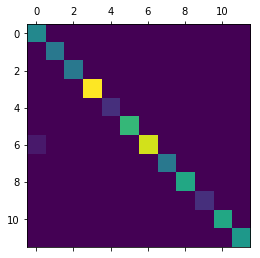

In [69]:
metrics(y, max_preds, True)

# Test Predictions

In [16]:
log_preds_test = learn.predict(is_test=True)
log_preds_test.shape

TypeError: 'NoneType' object is not iterable

In [17]:
max_preds = np.argmax(log_preds_test, 1)

NameError: name 'log_preds_test' is not defined

In [ ]:
preds_classes = [data.classes[i].replace("_", " ") for i in max_preds]
submission = pd.DataFrame({'file': os.listdir(f'{PATH}test'), 'species': preds_classes})
submission.to_csv(PATH + 'submission_resnet_152_all.csv', index=False)